In [1]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import torch

from environments.onestep import ARESEAOneStep
from oneshot0script import GaussianActor, Simulation

initializing ocelot...


## Bayesian Optimisation

In [2]:
env = ARESEAOneStep()
observation = env.reset()
before = env.segment.AREABSCR1.reading

In [3]:
def objective_fn(q1, q2, q3, cv, ch):
    action = np.array([q1, q2, q3, cv, ch])
    _, reward, _, _ = env.step(action)
    return reward

In [4]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [5]:
optimizer = BayesianOptimization(
    f=objective_fn,
    pbounds=pbounds
)
optimizer.maximize()

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  4.653    |  0.117    |  0.7121   | -0.3364   |  0.2931   | -0.5384   |
|  2        |  3.852    |  0.1188   |  0.5697   |  0.7634   | -0.8242   | -0.2222   |
|  3        |  5.012    | -0.4797   | -0.2393   | -0.275    |  0.7225   | -0.2667   |
|  4        |  4.629    |  0.5814   |  0.4683   | -0.2414   |  0.7403   |  0.01716  |
|  5        |  3.658    |  0.2374   |  0.7334   |  0.9435   | -0.04483  | -0.1257   |
|  6        |  3.962    |  0.09937  | -0.689    | -1.0      |  1.0      | -1.0      |
|  7        |  4.192    | -0.5709   |  0.3557   | -0.5501   |  0.8103   |  0.1112   |
|  8        |  3.588    |  0.04849  |  0.2029   |  0.4264   | -0.1805   |  0.9475   |
|  9        |  4.338    | -0.000245 |  0.1548   | -0.6054   |  0.414    | -0.4523   |
|  10       |  3.967    | -0.3047   | -0.2412   |  0.1

Desired: [-0.00164449  0.00169064  0.00038195  0.00012883]
Objective: 5.554003449377157


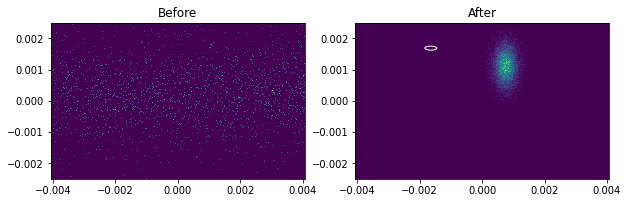

In [6]:
print("Desired:", env.desired)

screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

_, reward, _, _ = env.step(np.array([
    optimizer.max["params"]["q1"],
    optimizer.max["params"]["q2"],
    optimizer.max["params"]["q3"],
    optimizer.max["params"]["cv"],
    optimizer.max["params"]["ch"]
]))
print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

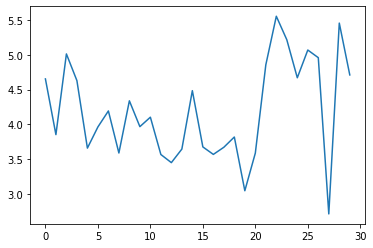

In [7]:
plt.plot(optimizer.space.target)
plt.show()

In [8]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([-2.6034176e+01, -2.1403887e+01, -1.5206429e+01,  2.1545087e-04,
       -2.2859722e-03, -1.6444919e-03,  1.6906369e-03,  3.8194944e-04,
        1.2883227e-04,  1.1529689e-02,  1.8190838e-04,  2.3727208e-02,
        9.3501003e-04], dtype=float32)

In [9]:
def target_fn(q1, q2, q3, cv, ch):
    normalized_actuators = np.array([q1, q2, q3, cv, ch])
    actuators = normalized_actuators * simulation.actuator_space.high
    
    achieved = simulation.track(actuators)
    
    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return -np.log((weights * np.abs(offset)).sum())
    
    return objective_fn(achieved, simulation.desired)

In [10]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [11]:
optimizer = BayesianOptimization(
    f=target_fn,
    pbounds=pbounds
)
optimizer.maximize()

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  3.927    | -0.2259   | -0.5729   |  0.04744  | -0.9272   |  0.8408   |
|  2        |  4.582    |  0.2145   |  0.5159   | -0.7739   |  0.5527   | -0.71     |
|  3        |  3.009    | -0.9184   | -0.7971   | -0.4179   | -0.629    | -0.9595   |
|  4        |  3.957    | -0.3335   | -0.1462   | -0.1905   |  0.9759   |  0.2467   |
|  5        |  3.836    |  0.4904   |  0.7728   | -0.6041   | -0.4707   |  0.8234   |
|  6        |  4.509    |  0.1268   |  0.4056   | -0.6181   |  0.8012   | -0.4079   |
|  7        |  4.403    |  1.0      |  1.0      | -0.4023   |  1.0      | -1.0      |
|  8        |  3.957    | -0.5645   |  1.0      | -1.0      |  1.0      | -1.0      |
|  9        |  4.256    |  1.0      | -0.1084   | -1.0      |  0.9702   | -0.7798   |
|  10       |  3.546    |  0.8343   |  1.0      | -1.0

Desired: [-0.00164449  0.00169064  0.00038195  0.00012883]
Objective: 4.904158392101866


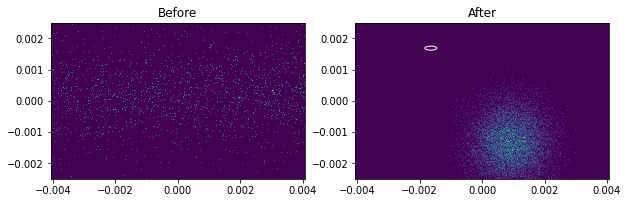

In [12]:
print("Desired:", env.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

objective = target_fn(**optimizer.max["params"])

print("Objective:", objective)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

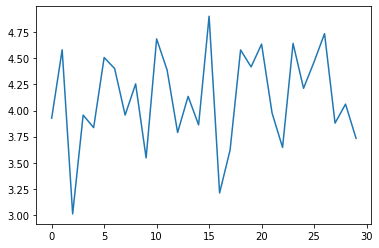

In [13]:
plt.plot(optimizer.space.target)
plt.show()

## Reinforcement Learning

In [14]:
timestamp = "20210908093749"
model = torch.load(f"models/onestep-model-{timestamp}.pkl")

Objective: 4.354991850965902


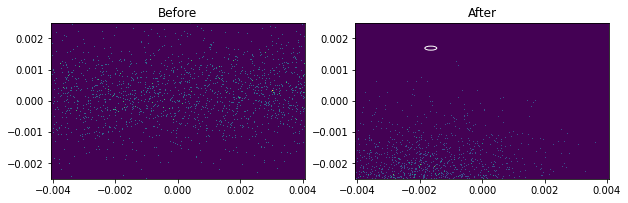

In [15]:
screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

torched_observation = torch.tensor(observation, dtype=torch.float32)
unsqueezed_observation = torched_observation.unsqueeze(0)
unsqueezed_actuators = model(unsqueezed_observation).sample()
torched_actuators = unsqueezed_actuators.squeeze()
actuators = torched_actuators.detach().numpy()
_, reward, _, _ = env.step(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

In [16]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([-2.6034176e+01, -2.1403887e+01, -1.5206429e+01,  2.1545087e-04,
       -2.2859722e-03, -1.6444919e-03,  1.6906369e-03,  3.8194944e-04,
        1.2883227e-04,  1.1529689e-02,  1.8190838e-04,  2.3727208e-02,
        9.3501003e-04], dtype=float32)

Objective: 4.354991850965902


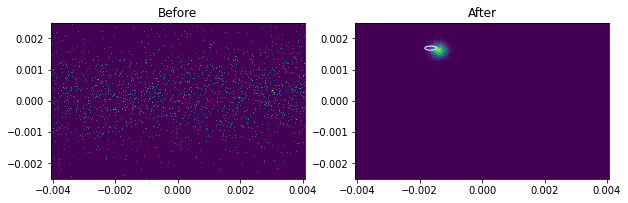

In [17]:
screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

observation_factor = np.concatenate([
    simulation.actuator_space.high,
    simulation.goal_space.high,
    simulation.goal_space.high
])

normalized_observation = observation / observation_factor
normalized_observation = torch.tensor(normalized_observation, dtype=torch.float32)
unsqueezed_observation = normalized_observation.unsqueeze(0)

unsqueezed_actuators = model(unsqueezed_observation).sample()

normalized_actuators = unsqueezed_actuators.squeeze()
actuators = normalized_actuators.detach().numpy() * simulation.actuator_space.high

simulation.track(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = simulation.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

## Bla bla

In [5]:
simulation = Simulation()
sobservation = simulation.reset()

env = ARESEAOneStep()
eobservation = env.reset(
    incoming=simulation.incoming,
    initial_actuators=simulation.initial_actuators,
    desired=simulation.desired
)

print("Simulation:", sobservation)
print("Environment:", eobservation)

Simulation: [-2.7002338e+01  7.2857599e+00  9.9064236e+00 -2.4748729e-03
 -3.8439953e-03  9.6334796e-04  1.9388990e-03  4.5353829e-04
  4.4328434e-04 -7.2115264e-04 -4.8267753e-03  2.0824231e-03
  1.2261964e-02]
Environment: [-2.7002338e+01  7.2857599e+00  9.9064236e+00 -2.4748729e-03
 -3.8439953e-03  9.6334796e-04  1.9388990e-03  4.5353829e-04
  4.4328434e-04 -7.2115264e-04 -4.8267753e-03  2.0824231e-03
  1.2261964e-02]
